### 初始化
读取RNAbed

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
from sklearn.isotonic import IsotonicRegression
# font_manager.fontManager.addfont('/cluster/home/futing/miniforge-pypy3/envs/hic/fonts/Arial.ttf')
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
from scipy.stats import zscore
%cd /cluster2/home/futing/Project/panCancer/Analysis/conserve

/cluster2/home/futing/Project/panCancer/Analysis/conserve


In [ ]:
TF_list=['SOX2','POU3F2','SALL2','OLIG2']
# normal stem cell markers
stem_markers=['PROM1', 'POU5F1', 'NANOG', 'SOX2'] #cd133 = prom1 Integratin-6=ITGA6 OCT4=POU5F1
# cancer stem cell markers
CSC_marker=['PROM1','CD44','ITGA6','FUT4']#SSEA1=CD15=FUT4 Integratin-6=ITGA6
RNA=pd.read_csv('/cluster/home/futing/ref_genome/hg38_gencode/humanGTF',sep='\t',header=None)

In [10]:
RNA.loc[RNA[0].isin(TF_list),:]

,0,1,2,3,4,5
12885,SOX2,protein_coding,ENSG00000181449.4,chr3,181711925,181714436
21152,POU3F2,protein_coding,ENSG00000184486.10,chr6,98834574,98839458
41093,SALL2,protein_coding,ENSG00000165821.12,chr14,21521080,21537216
57732,OLIG2,protein_coding,ENSG00000205927.5,chr21,33025935,33029196


In [ ]:
RNA.loc[RNA[0]=='SOX2',:]

,0,1,2,3,4,5
52355,CCBE1,protein_coding,ENSG00000183287.15,chr18,59430939,59697662


### rotate 45 绘图

#### 单个 rotate

In [6]:
resolution = 10000  
#clr = cooler.Cooler(f'/cluster/home/futing/Project/GBM/HiC/02data/04mcool/useless/NPC.mcool::resolutions/{resolution}')
clr=cooler.Cooler(f'/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/10000/GBM_10000.cool')
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
#insulation_table = insulation(clr, windows, verbose=True)

In [7]:
# Functions to help with plotting
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True,fontsize=10):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.tick_params(axis='y', labelsize=fontsize)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.tick_params(axis='x', labelsize=fontsize)
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def add_colorbar(im, ax, size="3%", pad=0.1, aspect=4, label=False,label_name='Colorbar Label', labelsize=9):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad, aspect=aspect)
    cb = plt.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=labelsize)
    if label:
        cb.set_label(label, fontsize=labelsize)

In [6]:
clr=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/1000/GBM_1000.cool')
pixels=clr.pixels()[:]

In [7]:
pixels.loc[pixels['bin1_id']==pixels['bin2_id'],:]

,bin1_id,bin2_id,count
100,51,51,2
310,52,52,1
551,54,54,14
1347,62,62,14
1625,63,63,2
...,...,...,...
5686138173,3087936,3087936,162
5686138178,3087937,3087937,464
5686138182,3087938,3087938,599
5686138185,3087939,3087939,238


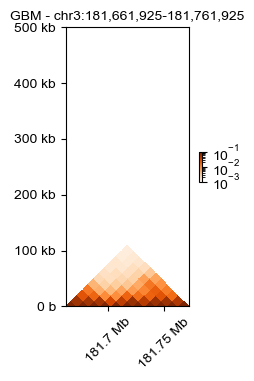

In [13]:

f, ax = plt.subplots(
    figsize=(8,6),
    sharey=True,sharex=True)
# 文件列表和文件夹路径

gene_name = 'SOX2'
resolution = 10000 
downstream= str(resolution/10000)+'kb'
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
chr_region = RNA.loc[RNA[0]==gene_name,3].values[0]
gene_position = RNA.loc[RNA[0]==gene_name,4].values[0]
start, end = max(gene_position - 50000, 0), gene_position + 50000
region =(chr_region, start, end)

# 数据读取
data = clr.matrix(balance=True).fetch(region)
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=LogNorm(vmax=0.1, vmin=0.001), cmap='Oranges')
ax.set_aspect(0.5)#横纵比
ax.set_ylim(0, 10*windows[1])

# colorbar title
add_colorbar(im,ax,labelsize=10,size="3%")
ax.set_title(f'GBM - {chr_region}:{start:,}-{end:,}', fontsize=10)
format_ticks(ax)

plt.tight_layout(rect=[0, 0, 1, 0.98])#rect=[0, 0, 1, 0.9] left bottom right top 最左 最下 最右 上面留出0.2%
#plt.subplots_adjust(top=0.97)



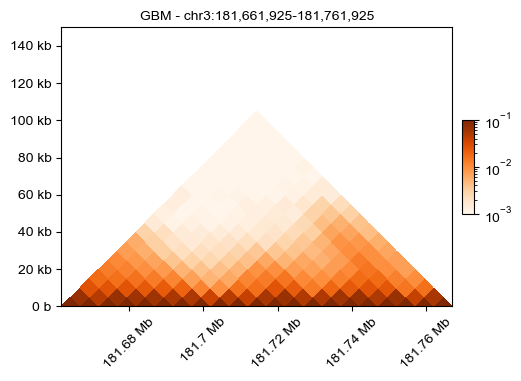

In [21]:
f, ax = plt.subplots(
    figsize=(8,6),
    sharey=True,sharex=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
# 文件列表和文件夹路径

gene_name = 'SOX2'
resolution = 5000 
downstream='50k'
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
chr_region = RNA.loc[RNA[0]==gene_name,3].values[0]
gene_position = RNA.loc[RNA[0]==gene_name,4].values[0]
start, end = max(gene_position - 50000, 0), gene_position + 50000
region =(chr_region, start, end)

# 数据读取
clr2=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/5000/GBM_5000.cool')
data = clr2.matrix(balance=True).fetch(region)
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=LogNorm(vmax=0.1, vmin=0.001), cmap='Oranges')
ax.set_aspect(0.5)#横纵比
ax.set_ylim(0, 10*windows[0])

# colorbar title
add_colorbar(im,ax,labelsize=10,size="3%")
ax.set_title(f'GBM - {chr_region}:{start:,}-{end:,}', fontsize=10)
format_ticks(ax)

plt.tight_layout(rect=[0, 0, 1, 0.98])#rect=[0, 0, 1, 0.9] left bottom right top 最左 最下 最右 上面留出0.2%
#plt.subplots_adjust(top=0.97)



#### batch rotate - given folder_path

In [16]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True,fontsize=10):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.tick_params(axis='y', labelsize=fontsize)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.tick_params(axis='x', labelsize=fontsize)
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [21]:
gene_list=stem_markers+CSC_marker+TF_list

In [13]:
from matplotlib.ticker import EngFormatter, FixedLocator, FixedFormatter
bp_formatter = EngFormatter('b')

def stack_plot(gene_name,resolution = 50000,folder_path='/cluster/home/futing/Project/GBM/HiC/02data/0350k',downstream='5MB',inch=5000000):
    f, axs = plt.subplots(
        figsize=(8,16),ncols=1,nrows=16,
        sharey=True,sharex=True)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial'] 
    plt.rcParams['pdf.fonttype'] = 42
    # 文件列表和文件夹路径
    windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
    chr_region = RNA.loc[RNA[0]==gene_name,3].values[0]
    gene_position = RNA.loc[RNA[0]==gene_name,4].values[0]
    gene_end = RNA.loc[RNA[0]==gene_name,5].values[0]
    start, end = max(gene_position - inch, 0), gene_position + inch
    region =(chr_region, start, end)
    ticks = [gene_position,gene_end]
    tick_labels = ['TSS','end']  # 修改为你希望显示的标签

    # 创建 FixedLocator 和 FixedFormatter
    fixed_locator = FixedLocator(ticks)
    fixed_formatter = FixedFormatter(tick_labels)

    cooler_file_list=glob.glob(f"{folder_path}/**/*_50k.kr.cool", recursive=True)
    NPC=f'/cluster/home/futing/Project/GBM/HiC/02data/04mcool/02NPC/NPC.mcool::resolutions/{resolution}'
    cooler_file_list=cooler_file_list+[NPC]
    for i, file in enumerate(cooler_file_list):
        if i==len(cooler_file_list)-1:
            filename='NPC'
        else:
            filename=file.split('/')[-1].split('_')[0]
        print(file)
        clr = cooler.Cooler(file)
        ax = axs.flat[i]

        # 绘图
        data = clr.matrix(balance=True).fetch(region)
        im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=LogNorm(vmax=0.1, vmin=0.001), cmap='fall')
        ax.set_aspect(0.5)#横纵比
        ax.set_ylim(0, 10*windows[1])
        ax.annotate(f'{filename}',xy=(1.02, 0.5),xycoords='axes fraction',fontsize=9,ha='left',va='center',rotation=90)
        ax.xaxis.set_minor_locator(fixed_locator)
        ax.xaxis.set_minor_formatter(fixed_formatter)
        for label in ax.xaxis.get_minorticklabels():
            label.set_rotation(45)
        format_ticks(ax)
        
    f.subplots_adjust(hspace=0.2,top=0.97)
    cbar_ax = f.add_axes([0.75, 0.3, 0.02, 0.4])
    f.colorbar(im, cax=cbar_ax,label='Corrected Contacts')
    plt.suptitle(f'{gene_name} - {chr_region}:{start:,}-{end:,} at 50k', fontsize=12,x=0.5,y=1)
    plt.savefig(f'./0350k/rotate/{downstream}/{gene_name}_{downstream}_NPC.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.5)


In [ ]:
# 定义一个函数来调用stack_plot函数
def apply_stack_plot(gene):
    stack_plot(gene, downstream='5MB', inch=5000000)

# 使用map函数调用apply_stack_plot函数
list(map(apply_stack_plot, gene_list))

In [ ]:
# 定义一个函数来调用stack_plot函数
def apply_stack_plot2(gene):
    stack_plot(gene, downstream='10MB', inch=10000000)

# 使用map函数调用apply_stack_plot函数
list(map(apply_stack_plot2, gene_list))

In [ ]:
# 定义一个函数来调用stack_plot函数
def apply_stack_plot2(gene):
    stack_plot(gene, downstream='1MB', inch=1000000)

# 使用map函数调用apply_stack_plot函数
list(map(apply_stack_plot2, gene_list))

#### batch rotate - given name

In [16]:
# 与上面的区别是，KR且只获取特定文件名的数据
from matplotlib.ticker import EngFormatter, FixedLocator, FixedFormatter
bp_formatter = EngFormatter('b')
def stack_plot_KR(gene_name,downstream='5MB',width=5,inch=5000000,resolution = 5000,folder_path='/cluster/home/futing/Project/GBM/HiC/02data/03cool/50000'):
    f, axs = plt.subplots(
        figsize=(width,8),ncols=1,nrows=4,
        sharey=True,sharex=True)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial'] 
    plt.rcParams['pdf.fonttype'] = 42
    # 定义start end region ticks tick_labels
    windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
    chr_region = RNA.loc[RNA[0]==gene_name,3].values[0]
    gene_position = RNA.loc[RNA[0]==gene_name,4].values[0]
    gene_end = RNA.loc[RNA[0]==gene_name,5].values[0]
    start, end = max(gene_position - inch, 0), gene_position + inch
    region =(chr_region, start, end)
    ticks = [gene_position,gene_end]
    tick_labels = ['TSS','end']  # 修改为你希望显示的标签

    # 创建 FixedLocator 和 FixedFormatter
    fixed_locator = FixedLocator(ticks)
    fixed_formatter = FixedFormatter(tick_labels)

    #cooler_file_list=['GBMmerge','ipsc','NPC','pHGG']
    cooler_file_list=['A172','A172_CPU']

    for i, file in enumerate(cooler_file_list):

        cooler_kr_file = glob.glob(f"{folder_path}/{file}_{resolution}.cool", recursive=True)
        print(f'Processing {cooler_kr_file}')
        clr = cooler.Cooler(cooler_kr_file[0])
        ax = axs.flat[i]

        # 绘图
        data = clr.matrix(balance=True).fetch(region)
        im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=LogNorm(vmax=0.1, vmin=0.001), cmap='fall')
        ax.set_ylim(0, 10*windows[0])
        ax.set_aspect(0.5)#横纵比
        ax.annotate(f'{file}',xy=(1.02, 0.5),xycoords='axes fraction',fontsize=9,ha='left',va='center',rotation=90)# 右侧注释
        ax.xaxis.set_minor_locator(fixed_locator)# 设置刻度
        ax.xaxis.set_minor_formatter(fixed_formatter)# 设置标签
        for label in ax.xaxis.get_minorticklabels(): # 设置标签旋转
            label.set_rotation(45)
        format_ticks(ax)
    f.subplots_adjust(hspace=0.2,top=0.97,right=0.85)
    cbar_ax = f.add_axes([0.9, 0.3, 0.02, 0.4]) # 添加colorbar 位置
    f.colorbar(im, cax=cbar_ax,label='Corrected Contacts')    
    
    
    plt.suptitle(f'{gene_name} - {chr_region}:{start:,}-{end:,} at 5k', fontsize=12,x=0.5,y=1)
    #plt.savefig(f'./0350k/rotate/{downstream}/{gene_name}_{downstream}_NPC.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.5)


Processing ['/cluster/home/futing/Project/GBM/HiC/02data/03cool/50000/A172_50000.cool']
Processing ['/cluster/home/futing/Project/GBM/HiC/02data/03cool/50000/A172_CPU_50000.cool']


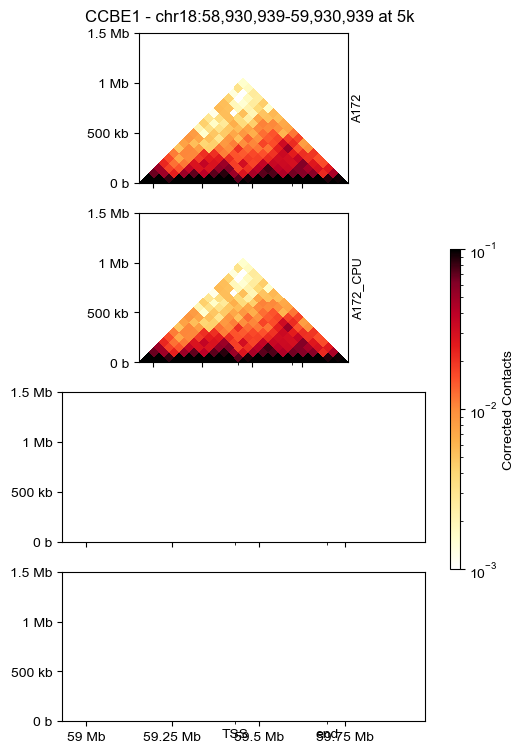

In [17]:
stack_plot_KR('CCBE1', downstream='0.5MB', resolution=50000,inch=500000,folder_path='/cluster/home/futing/Project/GBM/HiC/02data/03cool/50000')

### 正常方向

#### 单个正常方向

/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/10000/iPSC_merge_10000.cool


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 34 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'O', 'P', 'S', 'X', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'k', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 't', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 27, 38, 40, 44, 48, 50, 51, 54, 59, 68, 69, 70, 71, 72, 76, 78, 81, 82, 85, 86, 87, 237]
INFO:fontToo

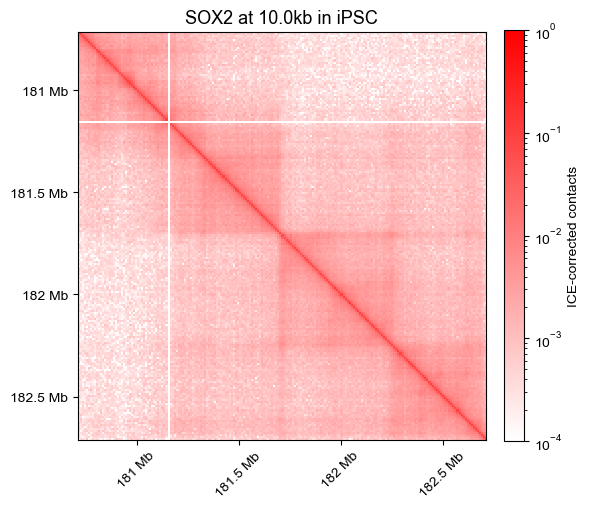

In [44]:
from matplotlib.colors import LinearSegmentedColormap
bp_formatter = EngFormatter('b')
#norm = LogNorm(vmax=50_000) 将数据转换为0-vmax
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45,labelsize=10)

f, ax = plt.subplots(
    figsize=(6,6),ncols=1,nrows=1,
    sharex=True, 
    sharey=True)

# 文件列表和文件夹路径
cell='iPSC'
reso=10000
res=str(reso/1000)+'kb'
file=f'/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/{reso}/{cell}_merge_{reso}.cool'
gene_name = 'SOX2'
chr_region = RNA.loc[RNA[0]==gene_name,3].values[0]
gene_position = RNA.loc[RNA[0]==gene_name,4].values[0]
start, end = max(gene_position - 1000000, 0), gene_position + 1000000

region =(chr_region, start, end)

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#1065ad', 'white', '#bc020f'])
filename=file.split('/')[-1].split('.')[0]
print(file)
clr = cooler.Cooler(file)
data= clr.matrix(balance=True).fetch(region)
im = ax.matshow(
    data,
    #vmax=5,
    norm=LogNorm(vmin=1e-04,vmax=1),# norm和log不能
    # cmap=custom_cmap,
    cmap=fruitpunch,
    extent=(start, end, end, start) #left right bottom top
); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='ICE-corrected contacts');
ax.set_title(f'{gene_name} at {res} in {cell}', fontsize=13)
format_ticks(ax)
#plt.suptitle(f'HiC map of {gene_name} at 50k', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.subplots_adjust(top=0.92)
plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/02data/hicplot/{gene_name}_{cell}_{res}_fruit.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.5)

#### batch 正常方向

/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts543_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts667_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/A172_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U118_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U343_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U87_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/SW1088_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/G523_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/G567_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/G583_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/04harewood/GB176_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/04harewood/GB180_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/04harewood/GB182_50k.kr.cool
/cluster/home/futing/Pr

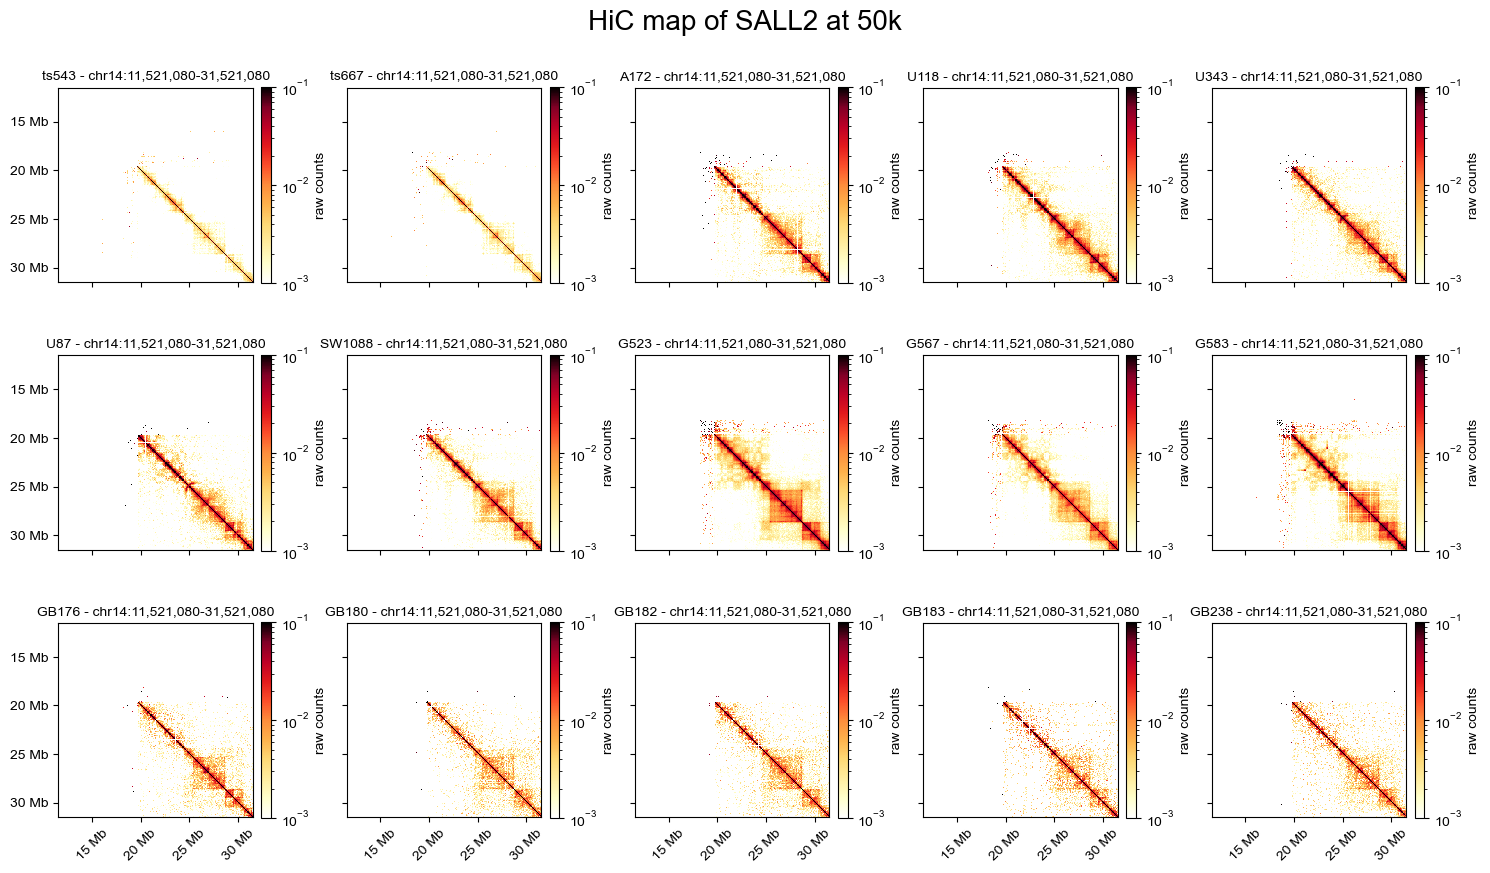

In [ ]:

# 多组
bp_formatter = EngFormatter('b')
#norm = LogNorm(vmax=50_000) 将数据转换为0-vmax
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45,labelsize=10)

f, axs = plt.subplots(
    figsize=(15,9),ncols=5,nrows=3,
    sharex=True, 
    sharey=True)

# 文件列表和文件夹路径
folder_path = '/cluster/home/futing/Project/GBM/HiC/02data/0350k'
gene_name = 'SALL2'
chr_region = RNA.loc[RNA[0]==gene_name,3].values[0]
gene_position = RNA.loc[RNA[0]==gene_name,4].values[0]
start, end = max(gene_position - 10000000, 0), gene_position + 10000000
region =(chr_region, start, end)
# 设置中间标记位置和标签
middle_tick = (start + end) // 2
ticks = [start, middle_tick, end]
#tick_labels=[start,gene_name,end]
tick_labels = [f'{start:,}', gene_name, f'{end:,}']
cooler_file_list=glob.glob(f"{folder_path}/**/*_50k.kr.cool", recursive=True)

for i, file in enumerate(cooler_file_list):
    cooler_kr_file = glob.glob(file)
    filename=file.split('/')[-1].split('_')[0]
    print(file)
    clr = cooler.Cooler(file)
    ax = axs.flat[i]
    im = ax.matshow(
        (clr.matrix(balance=True).fetch(region)),
        #vmax=5,
        norm=LogNorm(vmin=0.001,vmax=0.1),# norm和log不能
        #cmap=fruitpunch,
        cmap='fall',
        extent=(start, end, end, start) #left right bottom top
    ); 
    plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
    ax.set_title(f'{filename} - {chr_region}:{start:,}-{end:,}', fontsize=10)
    #ax.set_xticks(ticks)
    #ax.set_xticklabels(tick_labels)  # 方法1：设置字体大小
    # 方法2：使用tick_params设置字体大小
    #ax.tick_params(axis='x', labelsize=12)  
    format_ticks(ax)
plt.suptitle(f'HiC map of {gene_name} at 50k', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.subplots_adjust(top=0.92)

### 教程

#### norm
由于C数据具有很高的动态范围，我们通常在对数尺度上绘制数据。这使得我们可以在一致的颜色刻度下同时可视化靠近和远离对角线的特征。需要注意的是，未报告计数的区域在着色图中表现为白色条纹，通常出现在[着丝粒处]。这是因为这些高重复区域的读数无法被唯一映射。在矩阵平衡之前，这些区域会被屏蔽。
norm=LogNorm(vmin=0.001,vmax=0.1)

In [ ]:
ts543=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/04mcool/01our/ts667.mcool::resolutions/5000')

['/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/G523_50k.kr.cool']
['/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts543_50k.kr.cool']
['/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U87_50k.kr.cool']
['/cluster/home/futing/Project/GBM/HiC/02data/0350k/04harewood/GB180_50k.kr.cool']


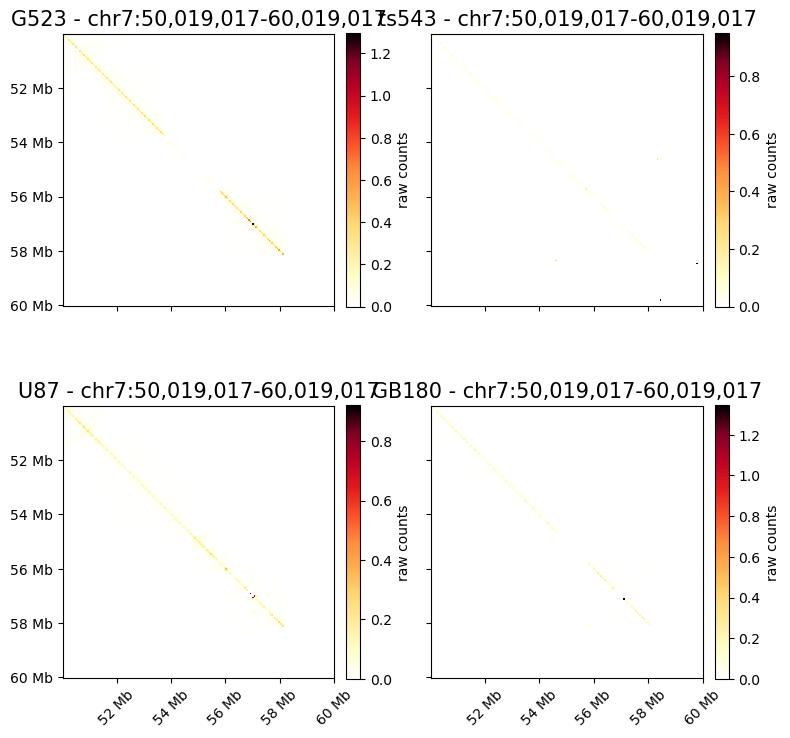

In [ ]:
bp_formatter = EngFormatter('b')
#norm = LogNorm(vmax=50_000) 将数据转换为0-vmax
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
f, axs = plt.subplots(
    figsize=(8,8),ncols=2,nrows=2,
    sharex=True, 
    sharey=True)

# 文件列表和文件夹路径
file_list = ["G523", "ts543", "U87", "GB180"]
folder_path = '/cluster/home/futing/Project/GBM/HiC/02data/0350k'

gene_name='EGFR'
chr_region = RNA.loc[RNA[0]==gene_name,3].values[0]
gene_position = RNA.loc[RNA[0]==gene_name,4].values[0]
start, end = max(gene_position - 5000000, 0), gene_position + 5000000
region =(chr_region, start, end)

for i, file in enumerate(file_list):
    cooler_kr_file = glob.glob(f"{folder_path}/**/{file}_50k.kr.cool", recursive=True)

    print(cooler_kr_file)
    clr = cooler.Cooler(cooler_kr_file[0])
    ax = axs.flat[i]
    im = ax.matshow(
        (clr.matrix(balance=True).fetch(region)),
        #vmax=5,
        norm=LogNorm(vmin=0.001,vmax=0.1),# norm和log不能
        cmap='fall',
        extent=(start, end, end, start) #left right bottom top
    ); 
    plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
    ax.set_title(f'{file} - {chr_region}:{start:,}-{end:,}', fontsize=15)
    format_ticks(ax)
plt.tight_layout()


#### balancing
clr_10kb.matrix(balance=True).fetch(region)
会让行和列的和为1

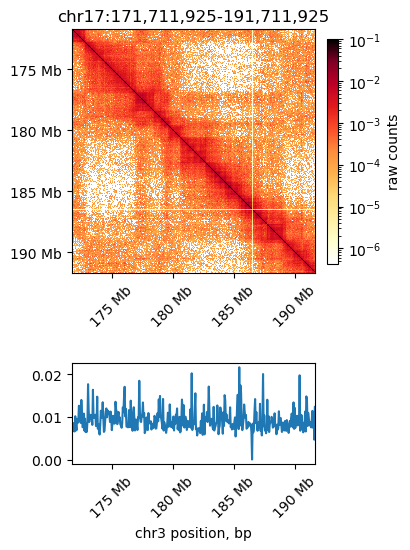

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cooler
import numpy as np

clr_10kb=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts543_50k.kr.cool')

plt_width=4
norm = LogNorm(vmax=0.1)
norm_raw = LogNorm(vmin=0, vmax=5)

f, axs = plt.subplots(
    figsize=(4,6),
    ncols=1,
    nrows=2,
    gridspec_kw={'height_ratios':[4,1],"wspace":0.01
                 #,'width_ratios':[1,.05]
                 }, # 色块的比例
    constrained_layout=True
)

chr_region = 'chr3'
start, end = 171711925, 191711925
region =(chr_region, start, end)

ax = axs[0]
im = ax.matshow(
    clr_10kb.matrix(balance=True).fetch(region), 
    norm=norm,  
    cmap='fall',
    extent=(start, end, end, start)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title(f'chr17:{start:,}-{end:,}')
#ax.xaxis.set_visible(False)
format_ticks(ax)

#cax = axs[0,1]
#plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04, label='corrected frequencies');

ax1 = axs[1]
weights = clr_10kb.bins().fetch(region)['weight'].values
ax1.plot(
    np.linspace(start, end, len(weights)),
    weights
)
format_ticks(ax1, y=False, rotate=False)
ax1.set_xlim(start, end);
ax1.set_xlabel('chr3 position, bp')
ax1.tick_params(axis='x',rotation=45)

#ax1 = axs[1,1]
#ax1.set_visible(False)

#### Coverage
在接触矩阵（contact matrices）中，染色体内接触和染色体间接触的倾向通常是不同的。这种接触倾向可以通过 cooltools.coverage 来计算，并且通常以 (cis_coverage/total_coverage) 的比率形式绘制。
total coverage 类似于迭代计算的平衡权重（balancing weights），但并不完全相同。
平衡权重是通过迭代校正方法计算的，用于去除接触矩阵中的乘法偏差，而 total coverage 则是直接计算得到的覆盖率

cis_coverage, tot_coverage = cooltools.coverage(clr)

/tmp/ipykernel_43600/223667253.py:34: RuntimeWarning: invalid value encountered in divide
  ax2.plot( cis_coverage/ tot_coverage)


Text(0, 0.5, 'coverage ratio')

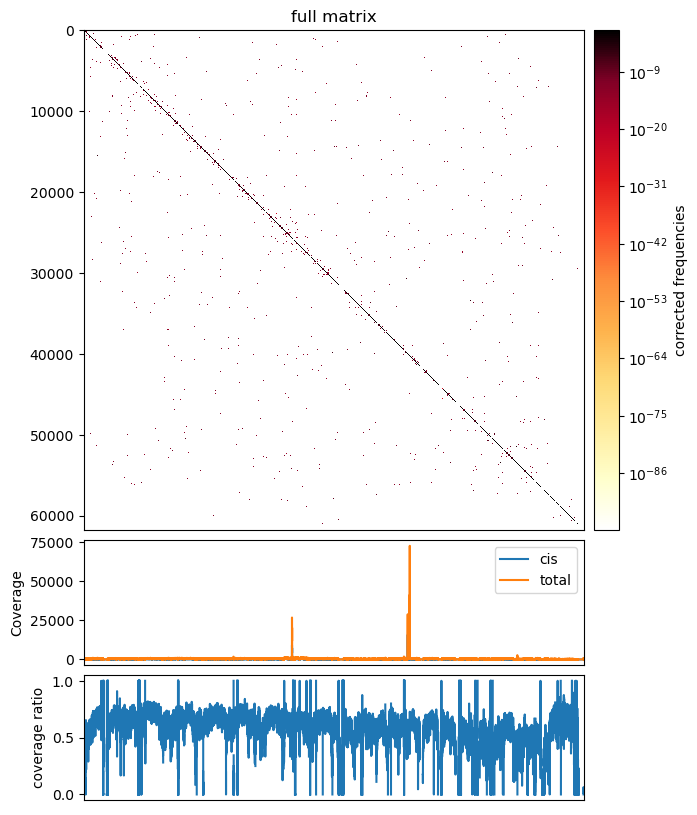

In [ ]:
import cooltools
cis_coverage, tot_coverage = cooltools.coverage(clr)

chr_region = 'chr3'
start, end = 171711925, 191711925
region =(chr_region, start, end)

f, ax = plt.subplots(
    figsize=(15, 10),
)


im = ax.matshow(
    clr.matrix()[:], 
    norm= LogNorm(vmax=0.1),  
    cmap='fall'
); 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_title('full matrix')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
weights = clr.bins()[:]['weight'].values
ax1.plot( cis_coverage, label='cis')
ax1.plot( tot_coverage, label='total')
ax1.set_xlim([0, len(clr.bins()[:])])
ax1.set_ylabel('Coverage')
ax1.legend()
ax1.set_xticks([])

ax2 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax2.plot( cis_coverage/ tot_coverage)
ax2.set_xlim([0, len(clr.bins()[:])])
ax2.set_ylabel('coverage ratio')

#### smoothing
处理高分辨率Hi-C, 推荐对矩阵进行平滑处理，cooltools 提供了 adaptive_coarsegrain 方法，用于自适应地平滑校正后的矩阵。
该方法根据原始矩阵中的计数情况进行平滑处理，即在计数较多的区域进行较少的平滑，在计数较少的区域进行较多的平滑。


cg = adaptive_coarsegrain(clr_10kb.matrix(balance=True).fetch(region),
                              clr_10kb.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)

cgi = interp_nan(cg)

In [ ]:
import importlib
importlib.reload(cooltools)



<module 'cooltools' from '/cluster/home/futing/anaconda3/envs/hic/lib/python3.10/site-packages/cooltools/__init__.py'>

/cluster/home/futing/anaconda3/envs/hic/lib/python3.10/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


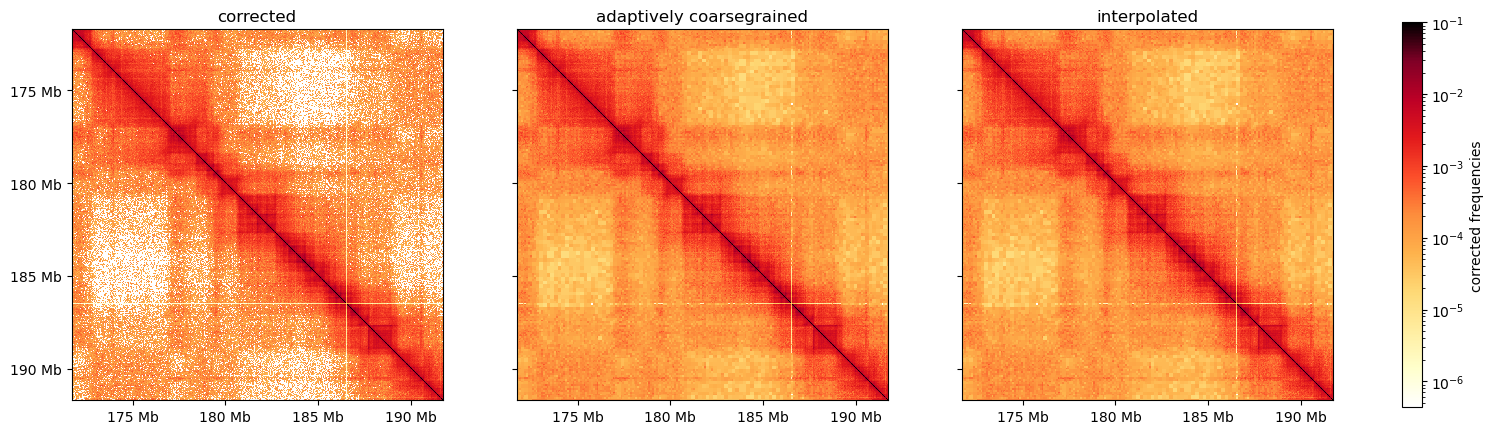

In [ ]:
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

clr_10kb=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts543_50k.kr.cool')
chr_region = 'chr3'
start, end = 171711925, 191711925
region =(chr_region, start, end)
extents = (start, end, end, start)
norm = LogNorm(vmax=0.1)

cg = adaptive_coarsegrain(clr_10kb.matrix(balance=True).fetch(region),
                              clr_10kb.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)

cgi = interp_nan(cg)

f, axs = plt.subplots(
    figsize=(18,5),
    nrows=1, 
    ncols=3,
    sharex=True, sharey=True)

ax = axs[0]
im = ax.matshow(clr_10kb.matrix(balance=True).fetch(region), cmap='fall', norm=norm, extent=extents)
ax.set_title('corrected')

ax = axs[1]
im2 = ax.matshow(cg, cmap='fall', norm=norm, extent=extents)
ax.set_title(f'adaptively coarsegrained')

ax = axs[2]
im3 = ax.matshow(cgi, cmap='fall', norm=norm, extent=extents)
ax.set_title(f'interpolated')

for ax in axs:
    format_ticks(ax, rotate=False)

plt.colorbar(im3, ax=axs, fraction=0.046, label='corrected frequencies')